### 오늘 할 것 : Custom Dataset을 이용하여 Ultralytics YOLO v3을 training

In [1]:
# Ultralytics Yolo v3 설치
!git clone https://github.com/ultralytics/yolov3

# requirements.txt 다운로드 : Ultralytics Yolov3을 사용하기 위한 여러 version관련 조건들이 명시되어 있는 문서
!cd yolov3;pip install -qr requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 10029, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10029 (delta 3), reused 9 (delta 3), pack-reused 10017
Receiving objects: 100% (10029/10029), 9.36 MiB | 30.91 MiB/s, done.
Resolving deltas: 100% (6762/6762), done.
     |████████████████████████████████| 1.8 MB 26.8 MB/s 
     |████████████████████████████████| 181 kB 69.3 MB/s 
     |████████████████████████████████| 157 kB 70.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 157 kB 72.3 MB/s 
     |████████████████████████████████| 157 kB 61.8 MB/s 
     |████████████████████████████████| 157 kB 77.2 MB/s 
     |████████████████████████████████| 157 kB 70.6 MB/s 
     |████████████████████████████████| 156 kB 72.4 MB/s 


In [2]:
# torch version과 GPU현황 출력
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.12.1+cu113 (Tesla T4)


### Oxford Pet Dataset 다운로드
* Oxford Pet 데이터를 다운로드 후 /content/data 디렉토리에 압축 해제. 

In [3]:
# Image 파일
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

# Annotation 파일
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2022-08-28 07:55:39--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2022-08-28 07:55:40--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  36.4MB/s    in 22s     

2022-08-28 07:56:02 (35.0 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-08-28 07:56:02--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.ta

In [4]:
# /content/data 디렉토리를 만들고 해당 디렉토리에 다운로드 받은 압축 파일 풀기.
!mkdir /content/data

# 이미지 파일 압축 해제
!tar -xvf images.tar.gz -C /content/data

# annotations 파일 압축 해제
!tar -xvf annotations.tar.gz -C /content/data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

### Oxford Pet Dataset 리뷰 및 학습/검증 데이터 세트로 분리
* Oxford Pet Dataset 개요
* Annotations 파일 : /data/annotations/xmls
* 이미지 파일 : /data/images
* /data/annotations/trainval.txt : 어떠한 anno파일과 image파일을 train, val로 사용할 것인가에 대한 정보
*  Pandas DataFrame으로 메타데이터 생성하고 이를 이용하여 학습과 검증 데이터 세트로 분리

* 우리의 최종 목표는 다음과 같은 디렉토리 구조로 만들어서 Ultralytics YOLO가 anno파일과 img파일을 구분할 수 있도록 하는 것이다
* /content/ox_pet/images/train/
* /content/ox_pet/images/val/
* /content/ox_pet/labels/train/
* /content/ox_pet/labels/val/

### 그래서 우리가 해야 할 것은
* Directory 구조를 위와 같이 맞추기
* Annotation 파일의 format을 Ultralytics YOLO와 맞추기
클래스명 CenterX CenterY Width Height 이렇게
* Dataset Config파일인 yaml을 수정하기
이렇게 3개이다

In [5]:
# Ultralytics Yolo의 Directory 구조에 맞추기 위하여 다음과 같이 한다
!mkdir /content/ox_pet;
!cd /content/ox_pet; mkdir images; mkdir labels;
!cd /content/ox_pet/images; mkdir train; mkdir val
!cd /content/ox_pet/labels; mkdir train; mkdir val

#/content/ox_pet/images/train
#/content/ox_pet/images/val
#/content/ox_pet/labels/train
#/content/ox_pet/labels/val
# 이런 디렉토리 들이 만들어진다

In [6]:
# 먼저 Ultralytics YOLO3 에서 사용하는 Annotation 파일의 형식으로 만들어 보자
# class명 + CenterX좌표 + CenterY좌표 + Width + Height 이렇게 5개의 컬럼으로 된 annotation파일을 만들어야 한다
import pandas as pd 

pd.read_csv('/content/data/annotations/trainval.txt', sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])

,img_name,class_id,etc1,etc2
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
3675,yorkshire_terrier_187,37,2,25
3676,yorkshire_terrier_188,37,2,25
3677,yorkshire_terrier_189,37,2,25
3678,yorkshire_terrier_18,37,2,25


In [7]:
'''
for index, row in pet_df.iterrows():
  print(index, row['anno_filepath'])
'''

"\nfor index, row in pet_df.iterrows():\n  print(index, row['anno_filepath'])\n"

In [8]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# 전체 image/annotation 파일명을 가지는 리스트 파일명을 입력 받아 메타 파일용 DataFrame 및 학습/검증용 DataFrame 생성. 
def make_train_valid_df(list_filepath, img_dir, anno_dir, test_size=0.1):
  pet_df = pd.read_csv(list_filepath, sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])
  #class_name은 image 파일명에서 맨 마지막 '_' 문자열 앞까지에 해당. 
  pet_df['class_name'] = pet_df['img_name'].apply(lambda x:x[:x.rfind('_')])
  
  # image 파일명과 annotation 파일명의 절대경로 컬럼 추가
  pet_df['img_filepath'] = img_dir + pet_df['img_name']+'.jpg'
  pet_df['anno_filepath'] = anno_dir + pet_df['img_name']+'.xml'

  # annotation xml 파일이 없는데, trainval.txt에는 리스트가 있는 경우가 있다.
  # 이런 경우 pet_df에서 해당 rows를 삭제하도록 한다 
  pet_df = remove_no_annos(pet_df)

  # 전체 데이터의 10%를 검증 데이터로, 나머지는 학습 데이터로 분리. 9:1의 비율로 분리한다
  train_df, val_df = train_test_split(pet_df, test_size=test_size, stratify=pet_df['class_id'], random_state=2021)
  return pet_df, train_df, val_df

# annotation xml 파일이 없는데, trainval.txt에는 리스트가 있는 경우에 이들을 dataframe에서 삭제하기 위한 함수.
def remove_no_annos(df):
  # 여기에는 DataFrame의 삭제된 row의 index들이 담기게 된다
  remove_rows = []

  # DataFrame의 index와 row를 모두 Loop돌며 방문한다
  # index에는 DataFrame의 각 row의 고유 인덱스가
  # 해당 row의 모든 정보들이 담긴다. 해당 row의 컬럼에는 다음과 같이 key를 통하여 접근이 가능하다
  for index, row in df.iterrows():
    anno_filepath = row['anno_filepath']
    # 만약 해당 파일이 실제로 존재하지 않는다면
    if not os.path.exists(anno_filepath):
      print('##### index:', index, anno_filepath, '가 존재하지 않아서 Dataframe에서 삭제함')
      #해당 DataFrame index를 remove_rows list에 담음. 
      remove_rows.append(index)
  # DataFrame의 index가 담긴 list를 drop()인자로 입력하여 해당 rows를 삭제
  df = df.drop(remove_rows, axis=0, inplace=False)
  return df


pet_df, train_df, val_df = make_train_valid_df('/content/data/annotations/trainval.txt', 
                                               '/content/data/images/', '/content/data/annotations/xmls/', test_size=0.1)

##### index: 4 /content/data/annotations/xmls/Abyssinian_104.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 262 /content/data/annotations/xmls/Bengal_111.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 1456 /content/data/annotations/xmls/samoyed_10.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2128 /content/data/annotations/xmls/Bengal_175.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2395 /content/data/annotations/xmls/Egyptian_Mau_14.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2402 /content/data/annotations/xmls/Egyptian_Mau_156.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2427 /content/data/annotations/xmls/Egyptian_Mau_186.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 3177 /content/data/annotations/xmls/Ragdoll_199.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 3246 /content/data/annotations/xmls/saint_bernard_15.xml 가 존재하지 않아서 Dataframe에서 삭제함


In [9]:
#print(train_df['class_name'].value_counts())
pet_df.head()

,img_name,class_id,etc1,etc2,class_name,img_filepath,anno_filepath
0,Abyssinian_100,1,1,1,Abyssinian,/content/data/images/Abyssinian_100.jpg,/content/data/annotations/xmls/Abyssinian_100.xml
1,Abyssinian_101,1,1,1,Abyssinian,/content/data/images/Abyssinian_101.jpg,/content/data/annotations/xmls/Abyssinian_101.xml
2,Abyssinian_102,1,1,1,Abyssinian,/content/data/images/Abyssinian_102.jpg,/content/data/annotations/xmls/Abyssinian_102.xml
3,Abyssinian_103,1,1,1,Abyssinian,/content/data/images/Abyssinian_103.jpg,/content/data/annotations/xmls/Abyssinian_103.xml
5,Abyssinian_105,1,1,1,Abyssinian,/content/data/images/Abyssinian_105.jpg,/content/data/annotations/xmls/Abyssinian_105.xml


In [10]:
# 실존하지 않는 annotation파일이 DataFrame에 잔존하는지 마지막으로 확인한다
import os

for index, row in pet_df.iterrows():
  anno_filepath = row['anno_filepath']
  if not os.path.exists(anno_filepath):
    print(anno_filepath)

### Oxford Pet 데이터 세트의 annotation을 Ultralytics Yolo format으로 생성.
* annotation용 xml 파일을 txt 파일로 변환한다
* 하나의 이미지당 하나의 anno txt파일이 있도록
* 확장자를 제외한 이미지의 파일명과 annotation 파일명이 서로 동일해야 함. 
* 하나의 xml annotation 파일을 Yolo 포맷용 txt 파일로 변환하는 함수 생성
* voc annotation의 좌상단(Top left: x1, y1), 우하단(Bottom right: x2, y2) 좌표를 Bounding Box 중심 좌표(Center_x, Center_y)와 너비(width), 높이(height)로 변경
* 중심 좌표와 너비, 높이는 원본 이미지 레벨로 scale 되어야 함. 모든 값은 0~1 사이 값으로 변환됨. 
* class_id는 여러개의 label들을 0 부터 순차적으로 1씩 증가시켜 id 부여

In [11]:
# Class 명을 부여. Class id는 자동적으로 CLASS_NAMES 개별 원소들을 순차적으로 0부터 36까지 부여
CLASS_NAMES = pet_df['class_name'].unique().tolist() # 고유한 class명을 list로 반환한다
print(CLASS_NAMES)

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [12]:
import glob
import xml.etree.ElementTree as ET

# 1개의 voc xml 파일을 Yolo 포맷용 txt 파일로 변경하는 함수 
def xml_to_txt(input_xml_file, output_txt_file, object_name):
  # ElementTree로 입력 XML파일 파싱. 
  tree = ET.parse(input_xml_file)
  root = tree.getroot()
  img_node = root.find('size')
  # img_node를 찾지 못하면 종료
  if img_node is None:
    return None
  # 원본 이미지의 너비와 높이 추출. 
  img_width = int(img_node.find('width').text)
  img_height = int(img_node.find('height').text)

  # xml 파일내에 있는 모든 object Element를 찾음. 
  value_str = None
  
  # 우리는 xml파일을 txt파일로 만들어(Write)해주어야 한다.
  # 그래서 다음과 같이 File Write Stream을 Open해준다
  with open(output_txt_file, 'w') as output_fpointer:
    for obj in root.findall('object'):
        # bndbox를 찾아서 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 추출. 
        xmlbox = obj.find('bndbox')
        x1 = int(xmlbox.find('xmin').text)
        y1 = int(xmlbox.find('ymin').text)
        x2 = int(xmlbox.find('xmax').text)
        y2 = int(xmlbox.find('ymax').text)
        # 만약 좌표중에 하나라도 0보다 작은 값이 있으면 종료. (즉, 좌표값에 오류가 있는 경우이다)
        if (x1 < 0) or (x2 < 0) or (y1 < 0) or (y2 < 0):
          break
        # object_name과 원본 좌표를 입력하여 Yolo 포맷으로 변환하는 convert_yolo_coord()함수 호출
        # 좌 상단, 우 하단, width, height를 입력하면 yolo format인 중심x, 중심y, width, height로 변환해준다
        class_id, cx_norm, cy_norm, w_norm, h_norm = convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2)
        # 변환된 yolo 좌표를 object 별로 출력 text 파일에 write
        value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, w_norm, h_norm)
        output_fpointer.write(value_str+'\n')
        # debugging용으로 아래 출력
        #print(object_name, value_str)

# object_name과 원본 좌표를 입력하여 Yolo 포맷으로 변환
def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):
  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출. 
  class_id = CLASS_NAMES.index(object_name)
  # 중심 좌표와 너비, 높이 계산. 
  center_x = (x1 + x2)/2
  center_y = (y1 + y2)/2
  width = x2 - x1
  height = y2 - y1

  # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = width / img_width # 원본 이미지의 width로 나눈다
  height_norm = height / img_height # 원본 이미지의 height로 나눈다

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)


In [13]:
 class_id = CLASS_NAMES.index('yorkshire_terrier')
 print(class_id)

36


In [14]:
# xml파일을 yolov3 format으로 변환해보기
xml_to_txt('/content/data/annotations/xmls/Abyssinian_1.xml', '/content/ox_pet/labels/train/Abyssinian_1.txt', 'Abyssinian')

### VOC Format의 여러개 xml 파일들을 Yolo format으로 변환 후 Ultralytics directory 구조로 입력
* VOC XML 파일들이 있는 디렉토리와 변환하여 출력될 Yolo format txt파일들이 있을 디렉토리를 입력하여 파일들을 생성. 

In [15]:
import shutil

# 이전에는 단일 이미지를 yolo data format으로 바꾸는 함수를 정의하였다.
# 이제는 해당 디렉토리의 모든 anno파일을 yolo format으로 변환해주는 함수를 정의한다.
def make_yolo_anno_file(df, tgt_images_dir, tgt_labels_dir):
  for index, row in df.iterrows():
    src_image_path = row['img_filepath']
    src_label_path = row['anno_filepath']
    # 이미지 1개당 단 1개의 오브젝트만 존재하므로 class_name을 object_name으로 설정.  
    object_name = row['class_name']
    # yolo format으로 annotation할 txt 파일의 절대 경로명을 지정. 
    target_label_path = tgt_labels_dir + row['img_name']+'.txt'
    
    # image의 경우 target images 디렉토리로 단순 copy
    # 파이썬의 shell utility의 copy메소드 이용
    shutil.copy(src_image_path, tgt_images_dir)
    # annotation의 경우 xml 파일을 target labels 디렉토리에 Ultralytics Yolo format으로 변환하여  만듬
    xml_to_txt(src_label_path, target_label_path, object_name)

# train용 images와 labels annotation 생성
# 이 train_df에는 모든 train 이미지 파일과 annotation파일의 절대경로를 가지고 있다
make_yolo_anno_file(train_df, '/content/ox_pet/images/train/', '/content/ox_pet/labels/train/')

# val용 images와 labels annotation 생성. 
# 이 train_df에는 모든 validation 이미지 파일과 annotation파일의 절대경로를 가지고 있다

make_yolo_anno_file(val_df, '/content/ox_pet/images/val/', '/content/ox_pet/labels/val/')

### Oxford Pet Dataset 학습 수행.
* 생성된 Directory 구조에 맞춰서 dataset용 yaml 파일 생성.  

In [16]:
# 
!wget -O /content/ox_pet/ox_pet.yaml https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml

--2022-08-28 07:56:54--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 754 [text/plain]
Saving to: ‘/content/ox_pet/ox_pet.yaml’

/content/ox_pet/ox_ 100%[===================>]     754  --.-KB/s    in 0s      

2022-08-28 07:56:54 (50.5 MB/s) - ‘/content/ox_pet/ox_pet.yaml’ saved [754/754]



In [ ]:
### train시 1시간 정도 소모 되기 때문에. Autoclick을 해주는 다음 Javascript code를 console에 입력해주었다

'''
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
'''

In [18]:
# 혹시 모를 불상사에 대비한다.
# 학습시간이 매우 오래 걸리기 때문에, 학습 도중 갑자기 kernel out될 가능성을 대비하여
# Google Drive를 Mount한 이후 가중치를 저장할 것이다

import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# soft link로 Google Drive Directory 연결. 
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
# Google Drive 밑에 Directory 생성. 이미 생성 되어 있을 시 오류 발생. 
# 아래에 가중치파일을 주기적으로 update할 것이다
!mkdir "/mydrive/ultra_workdir"

In [22]:
###  10번 미만 epoch는 좋은 성능이 안나옴. 최소 30번 이상 epoch 적용.
## Ultralytics YOLO는 학습 epoch가 적으면 성능이 매우 떨어진다.
## --no-save 옵션이 없다면. 20회의 validation중 2개의 가중치 파일이 저장되는데, 다음과 같다
# 1. 20회 의 validation 중에서 가장 Loss가 적은 경우의 가중치를 저장 : best.pt
# 2. 마지막 epoch 수행 직후의 가중치를 저장 : last.pt

!cd /content/yolov3; python train.py --img 640 --batch 16 --epochs 20 --data /content/ox_pet/ox_pet.yaml --weights yolov3.pt --project=/mydrive/ultra_workdir \
                                     --name pet --exist-ok 

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 3
wandb: You chose 'Don't visualize my results'
train: weights=yolov3.pt, cfg=, data=/content/ox_pet/ox_pet.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=/mydrive/ultra_workdir, name=pet, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov3 ✅
YOLOv3 🚀 v9.6.0-21-g92c3bd7 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, 

### 학습된 모델 파일을 이용하여 Inference 수행. 
* 이미지 파일과 영상 파일로 inference 수행. 

In [31]:
# image 파일 inference 시행
# inference는 detect.py 파일을 이용하여 시행한다

!cd yolov3;python detect.py --source /content/data/images/pug_100.jpg --weights /mydrive/ultra_workdir/pet/weights/best.pt --conf 0.2 \
                            --project=/content/data/output --name=run_image --exist-ok --line-thickness 2

detect: weights=['/mydrive/ultra_workdir/pet/weights/best.pt'], source=/content/data/images/pug_100.jpg, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/data/output, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 v9.6.0-21-g92c3bd7 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 261 layers, 61691290 parameters, 0 gradients, 155.2 GFLOPs
image 1/1 /content/data/images/pug_100.jpg: 640x448 1 pug, Done. (0.047s)
Speed: 0.5ms pre-process, 46.9ms inference, 1.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to /content/data/output/run_image


In [32]:
### video inference 시행
# target video를 다운로드 한다
!wget -O /content/data/ox_dog.mp4  https://github.com/chulminkw/DLCV/blob/master/data/video/ox_dog.mp4?raw=true

--2022-08-28 09:09:19--  https://github.com/chulminkw/DLCV/blob/master/data/video/ox_dog.mp4?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/ox_dog.mp4 [following]
--2022-08-28 09:09:19--  https://github.com/chulminkw/DLCV/raw/master/data/video/ox_dog.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/ox_dog.mp4 [following]
--2022-08-28 09:09:19--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/ox_dog.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

In [33]:
# inference 시작
# 여기서 --iou는 NMS iou threshold를 의미한다. 0.6 IOU라는 기준을 이용하여 non-maximum suppression수행한다
!cd yolov3; python detect.py --source /content/data/ox_dog.mp4 --weights /mydrive/ultra_workdir/pet/weights/best.pt \
                  --project /content/data/output --name run_video --exist-ok --line-thickness 3 --conf 0.4 --iou=0.6

detect: weights=['/mydrive/ultra_workdir/pet/weights/best.pt'], source=/content/data/ox_dog.mp4, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.6, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/data/output, name=run_video, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 v9.6.0-21-g92c3bd7 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 261 layers, 61691290 parameters, 0 gradients, 155.2 GFLOPs
video 1/1 (1/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, Done. (0.047s)
video 1/1 (2/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, Done. (0.045s)
video 1/1 (3/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, Done. (0.045s)
video 1/1 (4/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, Done. (0.032s)
video 1/1 (5/7

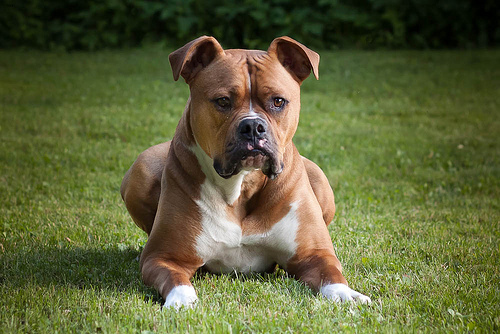

In [28]:
from IPython.display import Image, clear_output 

Image(filename='/content/data/images/american_bulldog_101.jpg', width=400)

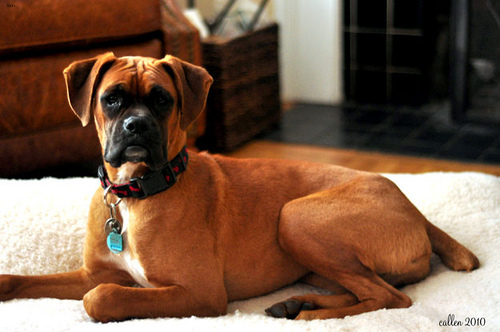

In [27]:
Image(filename='/content/data/images/boxer_100.jpg', width=400)

### test.py를 이용하여 Test 데이터를 Evalutation하기

In [29]:
# Run YOLOv3 on COCO val2017
!cd yolov3; python test.py --weights /mydrive/ultra_workdir/pet/weights/best.pt  --data /content/ox_pet/ox_pet.yaml \
                           --project /content/data/output --name=test_result --exist-ok --img 640 --iou 0.65



python3: can't open file 'test.py': [Errno 2] No such file or directory
